---
title: "Final Exam"
subtitle: "BMES 678"
author: "Tony Kabilan Okeke"
format: PrettyPDF-pdf
---

In [1]:
from scipy.interpolate import pchip_interpolate
from scipy import optimize as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy as sp
import requests

from typing import Callable
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

In [2]:
def rk4(
    fprime: Callable,
    timespan: tuple[float, float],
    y0: list[float],
    h: float = 0.1,
) -> tuple:
    """Fourth-Order Runge-Kutta method for solving ODEs"""

    x0, xend = timespan
    X = np.array([x0 + i * h for i in range(int(np.ceil((xend - x0) / h)))])
    Y = np.empty((len(X), len(y0)))
    Y[0, :] = y0

    for i in range(1, X.shape[0]):
        K1 = h * fprime(X[i - 1], Y[i - 1, :])
        K2 = h * fprime(X[i - 1] + h / 2, Y[i - 1, :] + K1 / 2)
        K3 = h * fprime(X[i - 1] + h / 2, Y[i - 1, :] + K2 / 2)
        K4 = h * fprime(X[i - 1] + h, Y[i - 1, :] + K3)
        Y[i, :] = Y[i - 1, :] + (K1 + 2 * K2 + 2 * K3 + K4) / 6

    return X, Y


def create_fig(
    xlab: str = "",
    ylab: str = "",
    xgrid: bool = True,
    ygrid: bool = True,
    lab_size: int = 11,
) -> None:
    fig, ax = plt.subplots(figsize=(5, 3))

    ax.minorticks_on()
    ax.spines[["top", "right"]].set_visible(False)

    if xlab:
        ax.set_xlabel(xlab, fontsize=lab_size)
    if ylab:
        ax.set_ylabel(ylab, fontsize=lab_size)

    if xgrid:
        ax.xaxis.grid(True, which="major", color="gray", alpha=0.6, linewidth=0.5)
        ax.xaxis.grid(
            True, which="minor", color="gray", alpha=0.6, linewidth=0.2, linestyle="--"
        )
    if ygrid:
        ax.yaxis.grid(True, which="major", color="gray", alpha=0.6, linewidth=0.5)
        ax.yaxis.grid(
            True, which="minor", color="gray", alpha=0.6, linewidth=0.2, linestyle="--"
        )
    return fig, ax


def downloadurl(url: str, filename: str) -> None:
    try:
        response = requests.get(url, verify=False)
        with open(filename, "w") as file:
            file.write(response.text)
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")

## Simulate the system with default parameters

Consider the following dynamical system:

\begin{align*}
\frac{dG}{dt} &= V - kG - \alpha \\ 
\frac{dV}{dt} &= \beta G - \delta G^3 -V
\end{align*}

where of V and G are two species whose concentrations change over time as governed by these differential equations; and the system parameters have the following default values: $\alpha = 1, \beta = 1.5, \delta = 0.1, k = 0.2$ 

Simulate this model with the default parameters and the default initial values **G= -2, V=2**. Show the concentrations of V and G over time (0 to 15 seconds) on the same plot. You may use the provided diff_exam_ahmet2(T,[G0 V0]) function with a -10% penalty to your grade; or create your own derivative function to avoid that penalty.

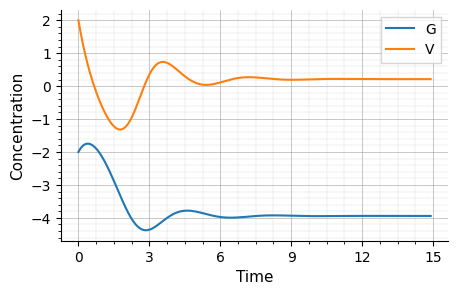

In [3]:
# | fig-align: center
# | fig-cap: "Concentration of V and G over time"

params = [1.0, 1.5, 0.1, 0.2]  # alpha, beta, delta, k


def diff_exam(t, Y, params):
    """Differential equations for the system"""
    G, V = Y
    alpha, beta, delta, k = params

    dGdt = V - k * G - alpha
    dVdt = beta * G - delta * G**3 - V

    return np.array([dGdt, dVdt])


# simulation
Y0 = [-2, 2]
tspan = (0, 15)
t, Y = rk4(lambda t, Y: diff_exam(t, Y, params), tspan, Y0)
G, V = Y.T

# plot
_, ax = create_fig(xlab="Time", ylab="Concentration", xgrid=True, ygrid=True)
ax.plot(t, G, label="G")
ax.plot(t, V, label="V")
ax.legend(loc="best", fancybox=False)
ax.set_xticks(np.arange(0, 16, 3))
ax.set_xticklabels(np.arange(0, 16, 3));

## Draw the nullclines

Draw the nullclines diagram for this system. You need to decide for yourself, which of the G or V to use as independent variable (ie. x axis of your plot). Your plot should be representative and should have all fixed points in view. You do not need to mark the fixed points on the nullclines figure.

The nullclines are defined as follows:

\begin{align*}
\frac{dG}{dt} = 0 &\implies V - kG - \alpha = 0  \\ 
\frac{dV}{dt} = 0 &\implies \beta G - \delta G^3 -V = 0 \\
\text{using G as the} &\text{ independent variable} \\
V &=  kG - \alpha\tag{nullcline G} \\
V &= \beta G - \delta G^3 \tag{nullcline V}
\end{align*}

(-6.0, 6.0)

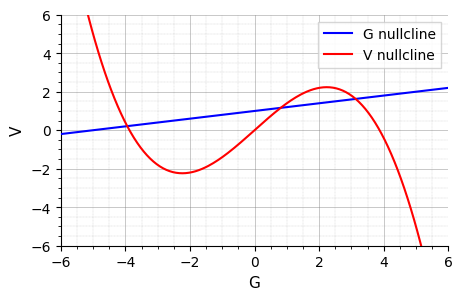

In [4]:
# | fig-align: center
# | fig-cap: "Nullclines of the system with G as the independent variable"


def nullcline_G(G, params):
    alpha, _, _, k = params  # alpha, beta, delta, k
    return k * G + alpha


def nullcline_V(G, params):
    _, beta, delta, _ = params  # alpha, beta, delta, k
    return beta * G - delta * G**3


# create a grid of G values
G_values = np.linspace(-10, 10, 400)

# compute nullclines
G_nullcline = nullcline_G(G_values, params)
V_nullcline = nullcline_V(G_values, params)

# plotting
_, ax = create_fig(xlab="G", ylab="V", xgrid=True, ygrid=True)
ax.plot(G_values, G_nullcline, label="G nullcline", color="blue", zorder=3)
ax.plot(G_values, V_nullcline, label="V nullcline", color="red", zorder=3)
ax.legend(loc="best", fancybox=False)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)

## Draw the phase diagram (on top of the nullclines figure)

Display phase diagram quivers on top of the nullcline diagram.

(-6.0, 6.0)

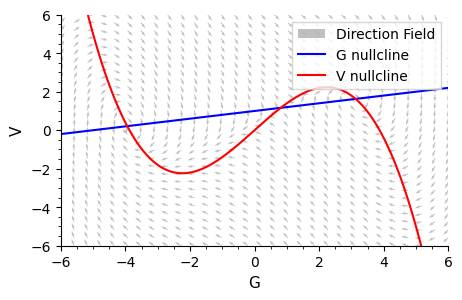

In [5]:
# | fig-align: center
# | fig-cap: "Phase diagram of the system overlaid with nullclines"

# compute gradients
gmesh, vmesh = np.meshgrid(np.linspace(-6, 6, 30), np.linspace(-6, 6, 30))
dg, dv = diff_exam(0, [gmesh, vmesh], params)
norm = np.sqrt(dg**2 + dv**2)
dg = dg / norm
dv = dv / norm

# plot
_, ax = create_fig(xlab="G", ylab="V", xgrid=False, ygrid=False)
ax.quiver(gmesh, vmesh, dg, dv, color="gray", alpha=0.5, label="Direction Field")
ax.plot(G_values, G_nullcline, label="G nullcline", color="blue")
ax.plot(G_values, V_nullcline, label="V nullcline", color="red")
ax.legend(loc="best", fancybox=False)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)

## Draw example integral curves (on top of the nullclines and phase diagram figure)

Run an example simulations with default parameters and with the default initial conditions on top of the nullclines & phase diagram figure. 

Run another example simulation with default parameters and with initial conditions of your choice, on top of the same figure. The initial conditions you choose must demonstrate a fixed point (converge to it or diverge from it), different than the fixed point demonstrated by the default parameters.

Use LineWidth=2 so the integral curves can be easily distinguished.

(-6.0, 6.0)

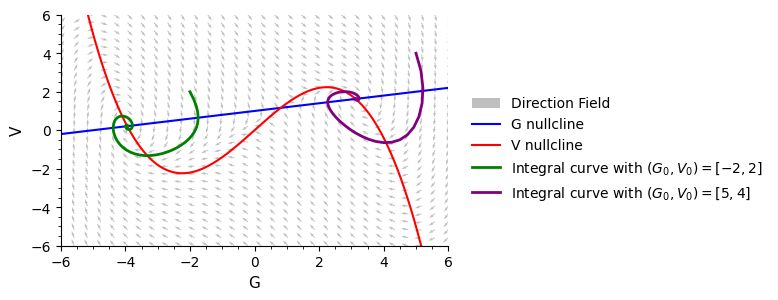

In [6]:
# | fig-align: center
# | fig-cap: "Integral curves, overlaid with nullclines and phase diagram"

# run simulation with default parameters
Y1 = [-2, 2]
t, Y = rk4(lambda t, Y: diff_exam(t, Y, params), tspan, Y1)
G1, V1 = Y.T

# run simulation with initial conditions of your choice
Y2 = [5, 4]
t, Y = rk4(lambda t, Y: diff_exam(t, Y, params), tspan, Y2)
G2, V2 = Y.T

# plot
_, ax = create_fig(xlab="G", ylab="V", xgrid=False, ygrid=False)
ax.quiver(gmesh, vmesh, dg, dv, color="gray", alpha=0.5, label="Direction Field")
ax.plot(G_values, G_nullcline, label="G nullcline", color="blue")
ax.plot(G_values, V_nullcline, label="V nullcline", color="red")
ax.plot(
    G1, V1, label=f"Integral curve with $(G_0, V_0) = {Y1}$", color="green", linewidth=2
)
ax.plot(
    G2,
    V2,
    label=f"Integral curve with $(G_0, V_0) = {Y2}$",
    color="purple",
    linewidth=2,
)
ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(1.03, 0.7))
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)

## Find the fixed point values of V & G analytically (strongly recommended) or numerically

What are the fixed points for the default parameters? Your output must print the values for the fixed points. Fill in only one of the following "analytically" or "numerically" sections. If you fill in both, your analytical solutions will be used for grading.

> I will be utilizing `sympy` to solve for the fixed points analytically.

In [7]:
# use sympy to solve the fixed points
G, V = sp.symbols("G, V")

# solve for the fixed points
eqns = [sp.Eq(d, 0) for d in diff_exam(0, [G, V], params)]
all_fixed_points = sp.solve(eqns, (G, V))

# identify and report real fixed points
IMG_THR = 0.0001
print("Fixed points:")
for G_val, V_val in all_fixed_points:
    if sp.im(G_val) < IMG_THR and sp.im(V_val) < IMG_THR:
        print(f"   (G, V) = ({sp.re(G_val):.2f}, {sp.re(V_val):.2f})")

Fixed points:
   (G, V) = (-3.94, 0.21)
   (G, V) = (0.81, 1.16)
   (G, V) = (3.13, 1.63)


## Bifurcation Diagram on the parameter $\beta$

Show the fixed point values of G only, for varying levels of beta. Other parameters should be kept at their default values. Vary the levels of beta by the following vector: [0:0.1:2]. Do not show any quiver arrows on your diagram. Only show the fixed point values of G. You may find the fixed points of G for each value of beta analytically or numerically. If you use analytical solutions, handle any imaginary fixed points as described above. If you use numerical solutions, ensure that all stable fixed points are discovered.

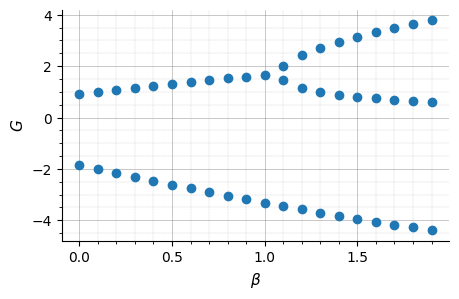

In [8]:
# | fig-align: center
# | fig-cap: "Bifurcation diagram on the parameter $\\beta$"

# initialize data for bifurcation diagram
new_params = params.copy()  # alpha, beta, delta, k
beta_vals = np.arange(0, 2, 0.1)
G_fixed_points = [[], []]  # beta, G

# solve for the fixed points
for beta in beta_vals:
    new_params[1] = beta
    eqns = [sp.Eq(d, 0) for d in diff_exam(0, [G, V], new_params)]
    all_fixed_points = sp.solve(eqns, (G, V))

    for G_val, V_val in all_fixed_points:
        if sp.im(G_val) < IMG_THR and sp.im(V_val) < IMG_THR:
            G_fixed_points[0].append(beta)
            G_fixed_points[1].append(sp.re(G_val))

# plot
_, ax = create_fig(xlab="$\\beta$", ylab="$G$", xgrid=True, ygrid=True)
ax.plot(G_fixed_points[0], G_fixed_points[1], "o")
ax.set_xticks(np.arange(0, 2, 0.5))
ax.set_xticklabels(np.arange(0, 2, 0.5));

## Parameter Optimization

Consider an extended model described by the following differential equations:

\begin{align*}
\frac{dG}{dt} &= V - kG - \alpha \\ 
\frac{dV}{dt} &= \beta G - \delta G^3 -V + \lambda \sin\left(\omega t\right)
\end{align*}

which includes the additional parameters $\lambda$, $\omega$ whose values are unknown. You are asked to estimate the values of $\lambda$, $\omega$ from experimental data. The experimental data is available in `experimentaldata.txt`.

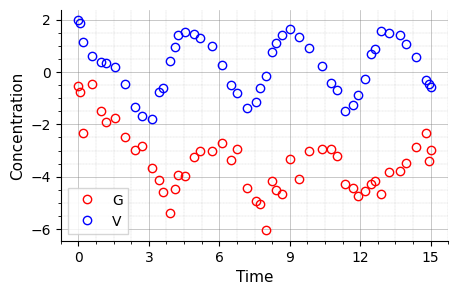

In [9]:
#| fig-align: center
#| fig-cap: "Experimental data"

# download data if necessary
datafile = Path("./experimentaldata2.txt").resolve()
if not datafile.exists():
    url = "https://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course:sim2:exam.20233b.th9bx:experimentaldata2.txt"
    downloadurl(url, datafile.name)

# load experimental data
df = pd.read_csv(datafile, sep="\t")
experimental = df.values

_, ax = create_fig(xlab="Time", ylab="Concentration", xgrid=True, ygrid=True)
ax.plot(experimental[:, 0], experimental[:, 1], "or", label="G", markerfacecolor="none")
ax.plot(experimental[:, 0], experimental[:, 2], "ob", label="V", markerfacecolor="none")
ax.legend(loc="best", fancybox=False)
ax.set_xticks(np.arange(0, 16, 3))
ax.set_xticklabels(np.arange(0, 16, 3));

Identify the parameters   that best replicate the experimental data. Assume the other parameters and the initial concentrations used in this experiment are the same as the default values listed above. Print the values of the best  parameters you find, along with the error they achieve. 

A derivative function that implements this system is provided for you as diff_exam_extended_ahmet2(T,Y, params), where Y is [G,V], params input is a vector of parameters [alpha,beta,delta, k, lambda,omega]. You may use this derivative function (without any penalties to your grade), or create your own.

You may use any optimization approaches and repeat optimization with different random guesses.

Consider using a faster ode solver function with a bigger time step, so the optimization runs faster. If you use a solver that you wrote previously, provide a copy of the solver function in this folder. If you are running an optimization procedure multiple times, consider customizing the optimization tolerance values to have the optimization procedure converge faster.

In [10]:
def diff_exam_extended(t, Y, params):
    """Differential equations for the system"""
    G, V = Y
    alpha, beta, delta, k, lambda_, omega = params

    dGdt = V - k * G - alpha
    dVdt = beta * G - delta * G**3 - V + lambda_ * np.sin(omega * t)

    return np.array([dGdt, dVdt])


def compute_mse(soln, experimental):
    """Compute the mean squared error between the solution and the experimental data"""

    Y = pchip_interpolate(soln[0], soln[1], experimental[:, 0])
    mse_G = np.mean((Y[:, 0] - experimental[:, 1]) ** 2)
    mse_V = np.mean((Y[:, 1] - experimental[:, 2]) ** 2)
    return (mse_G + mse_V) / 2


def plot_results(soln, experimental):
    """Plot the results of the simulation"""
    _, ax = create_fig(xlab="Time", ylab="Concentration", xgrid=True, ygrid=True)
    ax.plot(
        experimental[:, 0],
        experimental[:, 1],
        "or",
        label="G [experiment]",
        markerfacecolor="none",
    )
    ax.plot(
        experimental[:, 0],
        experimental[:, 2],
        "ob",
        label="V [experiment]",
        markerfacecolor="none",
    )
    ax.plot(soln[0], soln[1][:, 0], "r", label="G [simulation]", markerfacecolor="none")
    ax.plot(soln[0], soln[1][:, 1], "b", label="V [simulation]", markerfacecolor="none")
    ax.legend(loc="best", frameon=False, bbox_to_anchor=(1.03, 0.7))
    ax.set_xticks(np.arange(0, 16, 3))
    ax.set_xticklabels(np.arange(0, 16, 3))


def objective(optim_params, plot=False):
    """Objective function to identify values of lambda and omega"""
    if not hasattr(objective, "experimental"):
        objective.experimental = pd.read_csv("experimentaldata2.txt", sep="\t").values

    # simulation parameters
    tspan = (0, 15)
    Y0 = [-2, 2]
    params = [1.0, 1.5, 0.1, 0.2] + list(
        optim_params
    )  # alpha, beta, delta, k, lambda, omega

    # run simulation
    soln = rk4(lambda t, Y: diff_exam_extended(t, Y, params), tspan, Y0)

    if plot:
        plot_results(soln, objective.experimental)

    # compute MSE
    return compute_mse(soln, objective.experimental)


# run optimization
guess = [2.5, 1.5]
res = optim.minimize(objective, guess, method="Nelder-Mead")

print(f"""\
Best parameters (MSE = {res.fun:.4f}):
  lambda = {res.x[0]:.2f}
  omega = {res.x[1]:.2f}
""")

Best parameters (MSE = 0.1385):
  lambda = 1.97
  omega = 1.50



### Plot best-fit simulation vs. experimental data

Using the bestparameters and initial conditions you found above, now rerun the simulation with these optimized values. Plot the simulation data and experimental data on the same figure. Show experimental data as points (no lines connecting the points), and the simulation data as a line plot.

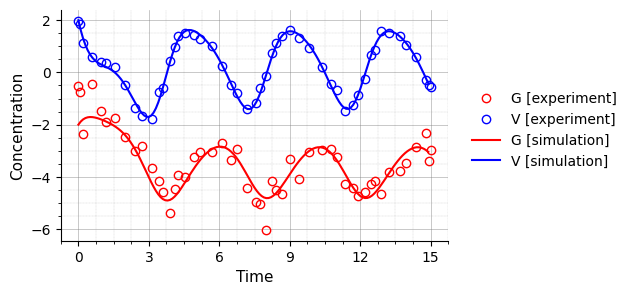

In [11]:
# | fig-align: center
# | fig-cap: "Best-fit simulation vs. experimental data"

_ = objective(res.x, plot=True)